## Introduction
In this notebook we will preprocess the data for our classification task.<br />
We will train a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge). => ***Please go this website and carefully read every little detail.***

At first we download the data from kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data), by clicking on "Download All" and extract it afterwards.

Acknowledgements:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

## Imports
* pathlib for convenient path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualizing some images
* tqdm for nice progress bar

In [21]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

You will get an error for installing `cv2` library. Google the error with proper mention of `cv2` and `Python` and try to fix it [.](https://stackoverflow.com/questions/37776228/pycharm-python-opencv-and-cv2-install-error)
<br> Hint: dot

At first, we read the csv file containing the labels

In [22]:
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

[WindowsPath('.ipynb_checkpoints'),
 WindowsPath('assets'),
 WindowsPath('weights'),
 WindowsPath('__pycache__')]

In [23]:
list(p.glob('**/*.ipynb'))

[WindowsPath('01-Preprocess.ipynb'),
 WindowsPath('02-plot_transforms_illustrations.ipynb'),
 WindowsPath('03-pytorch_lightning_simplest_example.ipynb'),
 WindowsPath('04-Train.ipynb'),
 WindowsPath('05-Interpretability.ipynb'),
 WindowsPath('.ipynb_checkpoints/01-Preprocess-checkpoint.ipynb'),
 WindowsPath('.ipynb_checkpoints/02-plot_transforms_illustrations-checkpoint.ipynb'),
 WindowsPath('.ipynb_checkpoints/03-pytorch_lightning_simplest_example-checkpoint.ipynb'),
 WindowsPath('.ipynb_checkpoints/04-Train-checkpoint.ipynb'),
 WindowsPath('.ipynb_checkpoints/Untitled-checkpoint.ipynb')]

In [24]:
p = Path('/Processed')
q = p / 'train' / '0'
q

WindowsPath('/Processed/train/0')

For `Path` function, refer to https://docs.python.org/3/library/pathlib.html

In [75]:
file_path = Path(r"C:\Users\zhenu\Desktop\rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
file_path.exists()

True

In [76]:
file_path.is_dir()

False

In [77]:
labels = pd.read_csv(file_path)

In [78]:
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [79]:
labels.shape

(30227, 6)

Note that subjects may occur multiple times in the dataset because different pneumonia spots are handled indivually. For our classification task, we can remove those duplicates as we are only interested in the binary label.

In [80]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")

In [81]:
type(labels)

pandas.core.frame.DataFrame

In [82]:
#explore
labels.

SyntaxError: invalid syntax (2747476676.py, line 2)

In [83]:
labels.shape

(26684, 6)

In [84]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Why can I use `labels.head` like this? ANS=>

Let's define the path to the dicom files and also the path were we want to store our processed npy files

In [85]:
ROOT_PATH = Path(r"C:\Users\zhenu\Desktop\rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path(r"C:\Users\zhenu\Desktop\rsna-pneumonia-detection-challenge/Processed/")

Let's look at some example images

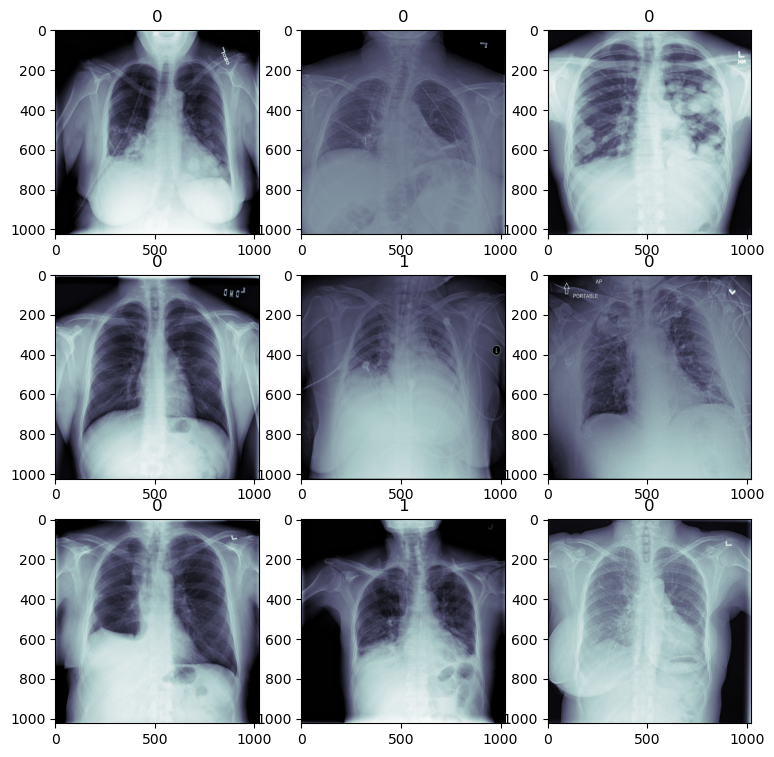

In [86]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

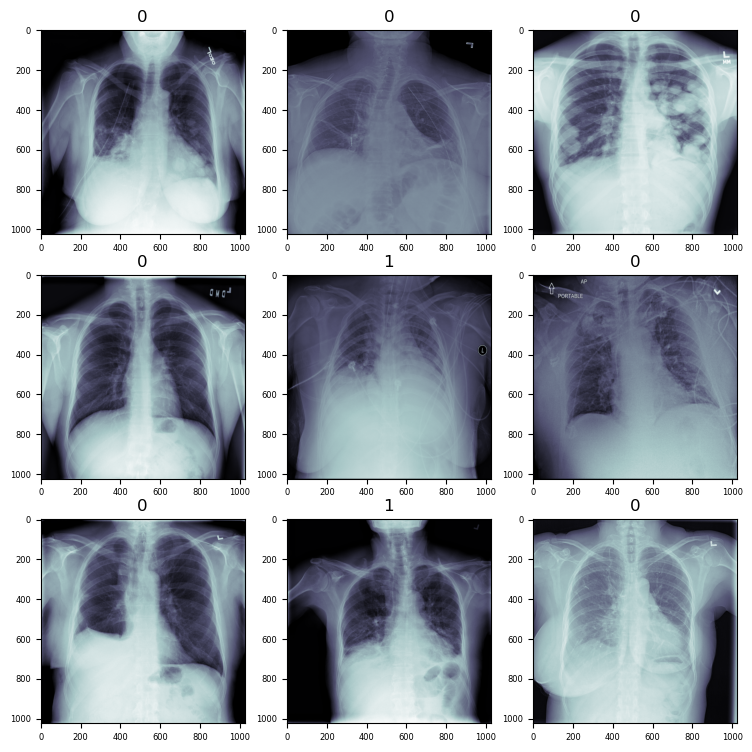

In [54]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        axis[i][j].tick_params(axis='both', which='major', labelsize=6)
        c+=1

ok, can you add this to the code above somewhere you think make sense? `axis[i][j].tick_params(axis='both', which='major', labelsize=4)`-What does it do? 

## Dicom Reading & Effective storage

In order to efficiently handle our data in the Dataloader, we convert the X-Ray images stored in the DICOM format to numpy arrays. Afterwards we compute the overall mean and standard deviation of the pixels of the whole dataset, for the purpose of normalization.
Then the created numpy images are stored in two separate folders according to their binary label:
* 0: All X-Rays which do not show signs of pneumonia
* 1: All X-Rays which show signs of pneumonia

To do so, we iterate over the patient ids and concat the patient ID with the ROOT_PATH.

We then directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
This allows to take advantage of the ready-to-use torchvision **DatasetFolder** for simple file reading


We standardize all images by the maximum pixel value in the provided dataset, 255.
All images are resized to 224x224.

To compute dataset mean and standard deviation, we compute the sum of the pixel values as well as the sum of the squared pixel values for each subject.
This allows to compute the overall mean and standard deviation without keeping the whole dataset in memory.


In [87]:
labels.patientId

0        0004cfab-14fd-4e49-80ba-63a80b6bddd6
1        00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2        00322d4d-1c29-4943-afc9-b6754be640eb
3        003d8fa0-6bf1-40ed-b54c-ac657f8495c5
4        00436515-870c-4b36-a041-de91049b9ab4
                         ...                 
30219    c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2
30221    c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8
30223    c1edf42b-5958-47ff-a1e7-4f23d99583ba
30224    c1f6b555-2eb1-4231-98f6-50a963976431
30225    c1f7889a-9ea9-4acb-b64c-b737c929599a
Name: patientId, Length: 26684, dtype: object

In [88]:
labels.patientId[1]

'00313ee0-9eaa-42f4-b0ab-c148ed3241cd'

In [91]:
dcm_path__ = ROOT_PATH/labels.patientId[1]
print(dcm_path__)
dcm_path__ = dcm_path__.with_suffix(".dcm")
print(dcm_path__)

C:\Users\zhenu\Desktop\rsna-pneumonia-detection-challenge\stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c148ed3241cd
C:\Users\zhenu\Desktop\rsna-pneumonia-detection-challenge\stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm


In [93]:
dcm= pydicom.dcmread(dcm_path__).pixel_array
print(dcm)
print(dcm.shape)

[[ 31  24  19 ... 191 183 176]
 [ 30  23  17 ... 127 128 128]
 [ 29  22  16 ...  90  95  98]
 ...
 [105 105 106 ... 157 156 154]
 [104 104 104 ... 155 154 152]
 [100 101 103 ... 153 153 151]]
(1024, 1024)


In [95]:
dcm = pydicom.dcmread(dcm_path__).pixel_array/255
print(dcm.dtype)

float64


In [97]:
dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

In [98]:
labels

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0


In [112]:
label = labels.Target.iloc[0]
print(label)
label = labels.Target[0]
print(label)

0
0


In [113]:
np.unique(labels.Target)

array([0, 1], dtype=int64)

In [115]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    
    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255  
        
    # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    # Retrieve the corresponding label
    label = labels.Target.iloc[c]
    
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val" 
        
    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

Change `tqdm(labels.patientId)` to this `labels.patientId`. What happens? ANS=>

***You need to remove the `break`, if you want to run the whole database***

If you want to stop a busy cell click on 'Interrupt' under 'Kernel' in the toolbar. Pressing `"I"` twice will also do the trick.
<br> https://stackoverflow.com/questions/36205356/how-should-i-stop-a-busy-cell-in-an-ipython-notebook

In [116]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

We will use mean and std later in the dataloader to normalize our data

In [117]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.4903962485384803, STD: 0.24795070634161256


-----